In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate/2).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
contrast = np.mean( librosa.feature.spectral_contrast(S=S, sr=sr).T, axis=0)
tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)

rmse = np.mean( librosa.feature.rmse(y=y).T, axis=0)
spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
zcr = np.mean( librosa.feature.zero_crossing_rate(y).T, axis=0)

def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

In [5]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav'):
        file_name=os.path.basename(file)
        fileID = file.split('/')[-1]
        features = get_features(file)
        X.append(features)
       # y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{20000} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X)

In [114]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))

            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

In [115]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')


labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')


X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 500/500 [00:54<00:00,  9.16it/s]


In [135]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (157, 184)
The shape of y is (157,)


In [136]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

#X.shape
X_new = SelectKBest(mutual_info_classif, k=10).fit_transform(X, y)
X_new.shape


(157, 10)

In [139]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 157
Numerical features extracted per sample: 10


,0,1,2,3,4,5,6,7,8,9
0,62.598813,0.814540,3.889203,15.180964,26.817322,18.275202,30.610331,1.674680,28.238022,0.902722
1,5.193614,0.642448,0.395949,0.204228,0.000117,0.003649,0.024437,0.007603,0.000152,-1.971972
2,26.854425,0.629808,0.119537,0.124463,11.145837,5.020247,0.053354,0.011623,0.001141,2.682902
3,28.076065,0.725543,8.123072,6.040123,0.020216,0.040254,0.007838,0.006207,0.000592,-0.493080
4,8.642074,0.599184,2.302726,3.428750,53.831413,127.825882,3.097013,1.540532,1.323891,-2.165058
...,...,...,...,...,...,...,...,...,...,...
152,26.741016,0.368318,1.205707,0.320997,1.368836,0.092577,0.062160,0.010174,0.121090,3.096365
153,2.075281,0.661835,0.127241,0.012972,8.480392,0.020971,0.000223,0.002570,0.000251,2.683386
154,58.039880,0.686358,13.617199,58.364067,5.333033,11.644874,0.333304,0.810545,0.464889,-2.075038
155,9.818892,0.679406,0.550521,2.186715,0.413410,0.226304,0.239764,0.151058,6.312653,0.109045


In [118]:
intonation_list = labels['intonation'].unique()
intonation_list

array(['question', 'excited', 'neutral', 'bored'], dtype=object)

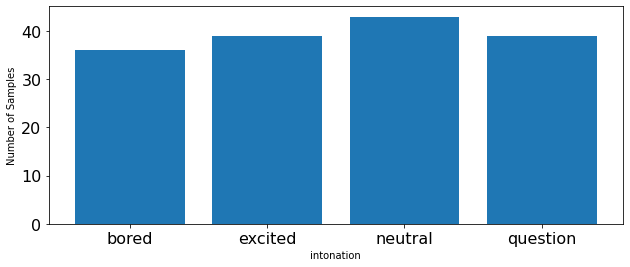

In [140]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [141]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [162]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)


In [156]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
1,SVC RBF kernel,46.88%
3,RandomForestClassifier,46.88%
4,AdaBoostClassifier,46.88%
2,DecisionTreeClassifier,40.62%
6,QuadraticDiscriminantAnalysis,40.62%
5,GaussianNB,37.50%
0,KNeighborsClassifier,31.25%


In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


param_grid = { 'C':[1,2,3,4,5,6,7,8,9,10,11,12],'kernel':['rbf'],'gamma': [2, 1, 0.1, 0.2, 0.3, 0.4, 0.5  ]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_scaled,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_test_scaled, y_val)))

#grid_predictions = grid.predict(X_val)
#print(confusion_matrix(y_val,grid_predictions))
#print(classification_report(y_val,grid_predictions))#Output

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.0s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.0s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.0s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.0s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=2, gamma=0.3, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.3, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.3, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.4, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.4, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.4, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.4, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.4, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.4, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.4, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.4, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.4, kernel=rbf ......................................
[CV] ....................... C=2, gamma=0.4, kernel=rbf, total=   0.0s
[CV] C=2, gamma=0.5, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    1.6s finished
